In [331]:
from fastai.vision.all import *
import albumentations

## Clean cache function
This function is useful when we try to implement with different models with limited `GPU` RAM

In [332]:
import gc
def clean_gpu(): 
    if not torch.cuda.is_available(): 
        print('GPU:', torch.mps.current_allocated_memory()/1024, 'MB')
        print('DRIVER:', torch.mps.driver_allocated_memory()/1024, 'MB')
        gc.collect()
        torch.mps.empty_cache()
    else: 
        print('GPU:', torch.cuda.list_gpu_processes(), 'MB')
        print('torch.cuda.memory_allocated():', torch.cuda.memory_allocated()/1024, 'MB')
        
        gc.collect()
        torch.cuda.empty_cache()
clean_gpu()

GPU: 312454.5 MB
DRIVER: 1207200.0 MB


## Config

In [358]:
import os
from pathlib import Path, PosixPath

def check_if_kaggle_environment():
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        return True
    else:
        return False


competition = 'paddy-disease-classification'
config = {
    'path': Path(f'../input/{competition}') \
        if check_if_kaggle_environment() else Path('./data') , 
    'train_path': Path(f'../input/{competition}/train_images') \
        if check_if_kaggle_environment() else Path('./data/train_images') , 
    'test_path': Path(f'../input/{competition}/test_images') \
        if check_if_kaggle_environment() else Path('./data/test_images') , 
    'item_size': 72, 
    'batch_size': 64, 
    'base_model': 'resnet26d'
    
}
config

{'path': Path('data'),
 'train_path': Path('data/train_images'),
 'test_path': Path('data/test_images'),
 'item_size': 72,
 'batch_size': 64,
 'base_model': 'resnet26d'}

## Create custom augmentation

In [334]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(size): return albumentations.Compose([
            albumentations.RandomResizedCrop(size,size, scale=0.75),
            albumentations.Transpose(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5),
            albumentations.CoarseDropout(p=0.5),
])

def get_valid_aug(size): return albumentations.Compose([
    albumentations.CenterCrop(size,size, p=1.),
    albumentations.Resize(size,size)
], p=1.)

## Model classification with only images (single target)

In [335]:
df = pd.read_csv(config['path']/'train.csv')
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [336]:
def get_variety(p: PosixPath) -> str: 
    return df[df['image_id'] == p.name]['variety'].item()

In [337]:
df['label'].value_counts()

label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

In [338]:
dls: DataLoader = DataBlock(
    blocks=[ImageBlock, CategoryBlock, CategoryBlock], 
    n_inp=1, 
    item_tfms=Resize(config['item_size'], method='squish'), 
    batch_tfms=[AlbumentationsTransform(get_train_aug(config['batch_size']), get_valid_aug(config['batch_size']))],
    get_items=get_image_files, 
    get_y=[parent_label, get_variety], 
    splitter=RandomSplitter(.2)
    
)\
.dataloaders(config['train_path']) 
# .dataloaders(config['train_path']/'bacterial_leaf_blight') # TODO change to original when finish 

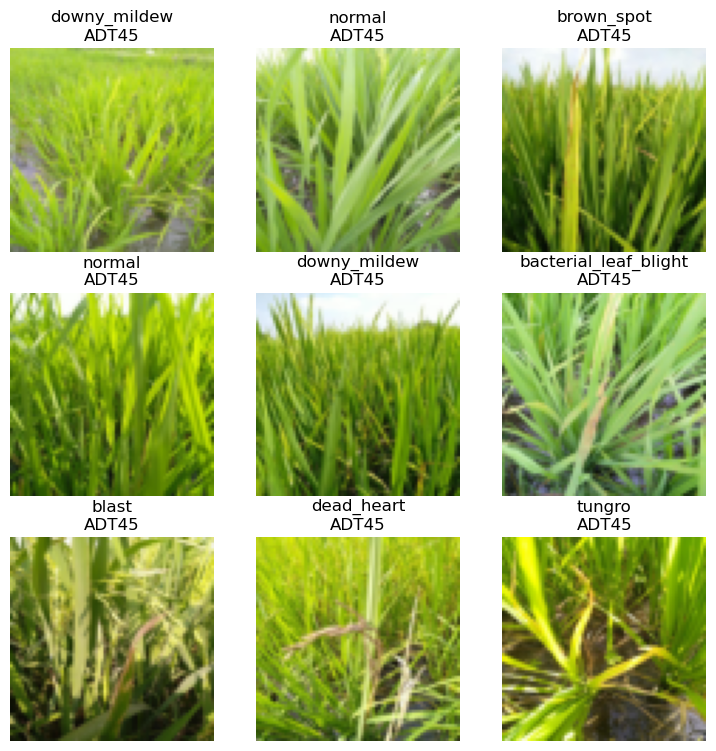

In [339]:
dls.show_batch()

In [340]:
test_files = get_image_files(config['test_path'])
test_files

(#3469) [Path('data/test_images/202919.jpg'),Path('data/test_images/200868.jpg'),Path('data/test_images/200698.jpg'),Path('data/test_images/200840.jpg'),Path('data/test_images/201586.jpg'),Path('data/test_images/203391.jpg'),Path('data/test_images/202931.jpg'),Path('data/test_images/202925.jpg'),Path('data/test_images/203385.jpg'),Path('data/test_images/200854.jpg')...]

### train function

In [342]:
def train(dls: DataLoader or None, loss_func, metrics, arch=config['base_model']\
        , n_out=10, epochs=1, fine_tune=True, \
            base_lr=0.01
    ): 
    if not dls: 
        pass
        # TODO: handle case where dls not pass
    learner = vision_learner(
        dls, arch, 
        n_out=n_out, 
        loss_func=loss_func, 
        metrics=metrics, 
    ).to_fp16()
    if fine_tune: 
        learner.fine_tune(epochs, base_lr)
    else:
        learner.fit_one_cycle(epochs, base_lr)
    return learner

## Loss and metrics for 1 target model

In [359]:
def loss_func(model_output: torch.Tensor, disease, variety): 
    return torch.nn.functional.cross_entropy(model_output, disease)
def metrics(model_output, disease, variety):
    return error_rate(model_output, disease)

In [343]:
# train(dls, loss_func, metrics=metrics)

In [344]:
# clean_gpu()

## Model classifcation with images and df (multiple targets)

Loss function and metrics for 2 targets

In [345]:
def loss_func_2(model_output: torch.Tensor, disease, variety): 
    disease_loss = torch.nn.functional.cross_entropy(model_output[:, :10], disease)
    variety_loss = torch.nn.functional.cross_entropy(model_output[:, 10:], variety)
    return disease_loss + variety_loss
    
def disease_err(model_output: torch.Tensor, disease, variety): return error_rate(model_output[:, :10], disease)
def variety_err(model_output: torch.Tensor, disease, variety): return error_rate(model_output[:, 10:], variety)

In [346]:
learner: Learner = train(dls, loss_func_2, metrics=(disease_err, variety_err), n_out=20, epochs=1)

epoch,train_loss,valid_loss,disease_err,variety_err,time
0,3.583219,2.535285,0.548294,0.250841,00:58


epoch,train_loss,valid_loss,disease_err,variety_err,time
0,1.955468,1.535140,0.337338,0.149447,01:02


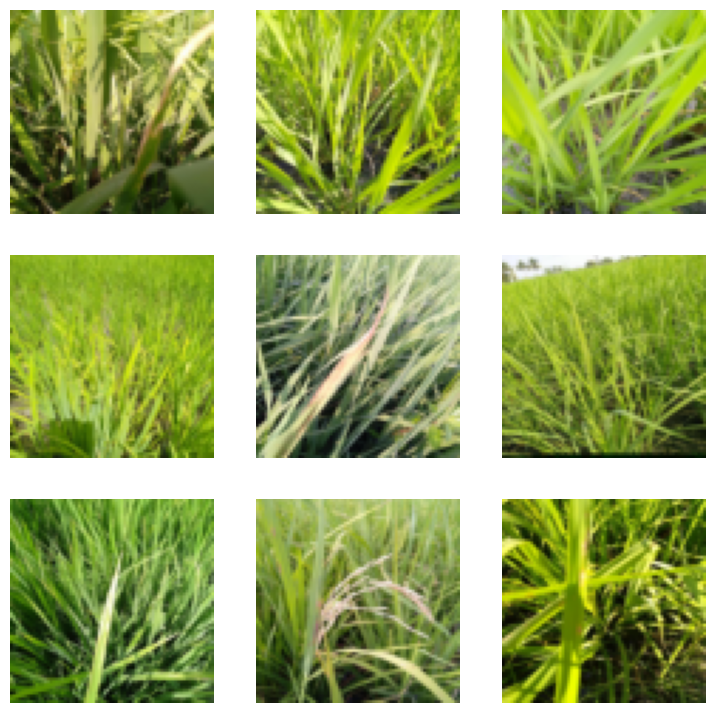

In [351]:
test_dls = learner.dls.test_dl(test_files)
test_dls.show_batch()

In [356]:
test_preds = learner.tta(dl=test_dls)

In [357]:
test_preds[0].shape

torch.Size([3469, 20])

In [376]:
idxs = np.array(test_preds[0][:, :10].argmax(-1))
idxs

array([3, 9, 8, ..., 3, 8, 7])

In [377]:
max(idxs)

9

In [378]:
vocab = np.array(learner.dls.vocab[0])
len(vocab)

10

In [380]:
vocab[idxs]

array(['blast', 'tungro', 'normal', ..., 'blast', 'normal', 'hispa'],
      dtype='<U24')

In [381]:
ss = pd.read_csv(config['path']/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [383]:
ss['label'] = vocab[idxs]
ss.to_csv('submission.csv', index=False)